In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('clean_data.csv')

/Users/yang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Feature Engineering

#### To keep things simple first:
#### 1.remove manager and rating data

In [3]:
data = data.drop(columns = ['Manager_Months_Managed', 'Manager_Current_Age','Manager_Age_At_Termination', 'Manager_Edu_Level',\
                            'Manager_Edu_Level_Year', 'Manager_YEARS_OF_SERVICE', 'Manager_OfColor','Manager_Job_Title',\
                            'Manager_Sex_F', 'Manager_Sex_M', 'Manager_Race_A', 'Manager_Race_B','Manager_Race_C', \
                            'Manager_Race_P', 'Manager_Race_R', 'Manager_Race_S','Manager_Race_U', 'Manager_Race_Z'])
data = data.drop(columns = 'avg_rating')

#### 2. remove home department data

In [4]:
data = data.drop(columns = ['HOME_DEPT_ORG', 'HOME_SCHOOL_CTR'])

#### 3. Remove Race_OfColor, JOB_TITLE and SEPARATION_REASON

In [5]:
data = data.drop(columns = ['Race_OfColor','JOB_TITLE', 'SEPARATION_REASON'])

#### 4. Make new age columns

Age/Time related columns
'Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE', 'MONTHS_IN_PRIMARY_JOB', 
'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'

1.Age_start: age when started to work at Penn: ORIGINAL_HIRE_DATE - Birth_Date <br>
2.Age_last: AGE_AT_TERMINATION or CURRENT_AGE if active <br>
3.MONTHS_IN_PRIMARY_JOB

Remove other Age/Time related columns other than the three above. <br>
TO GENERALIZE???: Should calculate using Date columns instead of using given age columns

In [6]:
date_cols = ['Birth_Date', 'PRIMARY_APPT_BEGIN_DATE','ORIGINAL_HIRE_DATE', 'TERMINATION_DATE']
for col in date_cols:
    data[col] = pd.DatetimeIndex(data[col])

In [7]:
# today = datetime.date.today()

In [8]:
# age = np.zeros(data.shape[0])
# for i in range(len(age)):
#     age[i] = relativedelta(data['ORIGINAL_HIRE_DATE'].iloc[i], data['Birth_Date'].iloc[i]).years
# data['Age_start'] = pd.Series(age)

In [9]:
data['Age_start'] = data['ORIGINAL_HIRE_DATE'] - data['Birth_Date']
data['Age_start'] = data['Age_start'].apply(lambda x: int(np.floor(x.days/365)))

In [10]:
data['Age_last'] = data['AGE_AT_TERMINATION'].fillna(data['CURRENT_AGE'])

In [11]:
data = data.drop(columns = ['Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE',\
                            'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'])

In [12]:
# x = np.array(data['PRIMARY_APPT_BEGIN_DATE'] == data['ORIGINAL_HIRE_DATE'])
# np.where(x==True)[0].shape

#### 5.job grade match

Remove job grade = 'PHR'<br>
Job grade A-H are IT positions and correspond to job grade 25-32 respectively <br>
Job grade U indicates in union: mostly maintenance people judging from their job titles, classify them as job grade 21(lowest in dataset) <br>
Add new column IS_IT <br>  


In [13]:
job_grade = {}

# create a dict that maps A-H to 25-32
for i,j in enumerate(range(25,33)):
    job_grade[chr(ord('A')+i)] = j
    
# new one-hot encoding columns IS_IT_0, IS_IT_1, 1 for yes, 0 for no
x = data['JOB_GRADE'].apply(lambda x: 1 if x in job_grade else 0)
df = pd.get_dummies(x).rename(lambda x: 'IS_IT_'+str(x), axis=1)
data = pd.concat([data, df], axis=1)

# convert letter job grades to numbers
job_grade['U'] = 21
data['JOB_GRADE'] = data['JOB_GRADE'].apply(lambda x: job_grade[x] if x in job_grade else x)

# Remove job grade = 'PHR'
data = data[data['JOB_GRADE']!='PHR']

data['JOB_GRADE'] = data['JOB_GRADE'].astype(int)

#### 6. convert education level to numbers

In [14]:
edu_map = {'B':0, 'C':1, 'F':1, 'E':1, 'D':1, 'G':2, 'H':3, 'K':4,'I':4, 'L':4, 'J':4}
data['EDUCATION_LEVEL'] = data['EDUCATION_LEVEL'].apply(lambda x: edu_map[x] if x in edu_map else None)

# Remove employees with no EDUCATION_LEVEL data
data = data[data['EDUCATION_LEVEL'].notnull()]

# remove EDUCATION_LEVEL_YEAR for now, 5000 missing values
data = data.drop(columns='EDUCATION_LEVEL_YEAR')

#### 7. add column: if visa terminates within a year of terminatino date/in two years if active

In [15]:
data['VISA_EXPIRATION_DATE'] = pd.DatetimeIndex(data['VISA_EXPIRATION_DATE'])
data = data.drop(columns = ['VISA','VISA_EXPIRATION_DATE'])

#### 8. US, Local

In [16]:
x = data['COUNTRY_OF_CITIZENSHIP'].isnull().astype(int)
y = data['HOME_CITY'].apply(lambda x: 1 if x == 'PHILADELPHIA' else 0)

df = pd.get_dummies(x).rename(lambda x: 'US_'+str(x), axis=1)
data = pd.concat([data, df], axis=1)

df = pd.get_dummies(y).rename(lambda x: 'Local_'+str(x), axis=1)
data = pd.concat([data, df], axis=1)

data = data.drop(columns = ['COUNTRY_OF_CITIZENSHIP','HOME_CITY'])

#### TO DO: 
1.partition by home school ctr <br>
2.Fiscal Year is ignored here <br>
3.

## Training Data Selection

##### remove rows where Starting_Full_Time_Salary is null

In [17]:
data = data[data['Starting_Full_Time_Salary'].notnull()]

### Data selection and partition criteria
1.we would like to partition people into two classes: who stayed more than T (active or terminated) and people who stayed less than T (only terminated) <br> 
2.two classes shouldn't be skewed

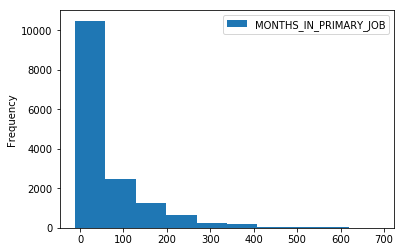

In [18]:
hist = data[['MONTHS_IN_PRIMARY_JOB']].plot.hist(bins=10)

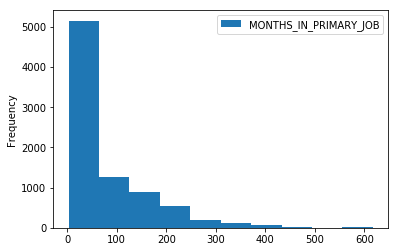

In [19]:
hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']!='T'].plot.hist(bins=10) 

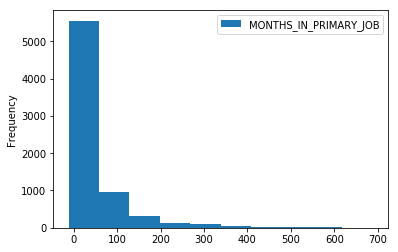

In [20]:
hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].plot.hist(bins=10)

#### seems like 4 years is a good place to set the threshold T

In [21]:
T = 48

In [22]:
label0 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)\
                           & (data['MONTHS_IN_PRIMARY_JOB']<=T)]
label1 = data[['Worker_ID']][((data['VOLUNTARY'].isnull()) | (data['VOLUNTARY'] == 1))\
                           & (data['MONTHS_IN_PRIMARY_JOB']>T)]
print(label0.shape,label1.shape,data.shape,sep=' ')
data = data.drop(columns = ['EMPLOYMENT_STATUS','VOLUNTARY'])

(4425, 1) (5509, 1) (15448, 43)


In [23]:
label0['label'] = 0
label1['label'] = 1
label = pd.concat([label0,label1],axis=0)

In [24]:
data = data.merge(label, how='right')
data.set_index('Worker_ID',inplace=True)

In [25]:
data.head()

,EDUCATION_LEVEL,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,JOB_GRADE,Starting_Full_Time_Salary,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,SEX_F,SEX_M,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,IN_UNION_0,IN_UNION_1,PAY_CYCLE_M1,PAY_CYCLE_W1,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,JOBS_ACTIVE_0,JOBS_ACTIVE_1,Age_start,Age_last,IS_IT_0,IS_IT_1,US_0,US_1,Local_0,Local_1,label
Worker_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.0,10,32714.00,25,26000.0,6714.00,0.2582,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,23,27.0,1,0,0,1,0,1,0
4,2.0,115,90815.00,29,65000.0,25815.00,0.3971,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,27,52.0,1,0,0,1,1,0,1
8,2.0,18,33014.00,24,31500.0,1514.00,0.0480,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,31,32.0,1,0,0,1,1,0,0
9,3.0,19,53170.00,27,52000.0,1170.00,0.0225,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,29,30.0,1,0,0,1,0,1,0
10,3.0,40,54695.56,28,50000.0,4695.56,0.0939,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,37,41.0,1,0,0,1,0,1,0


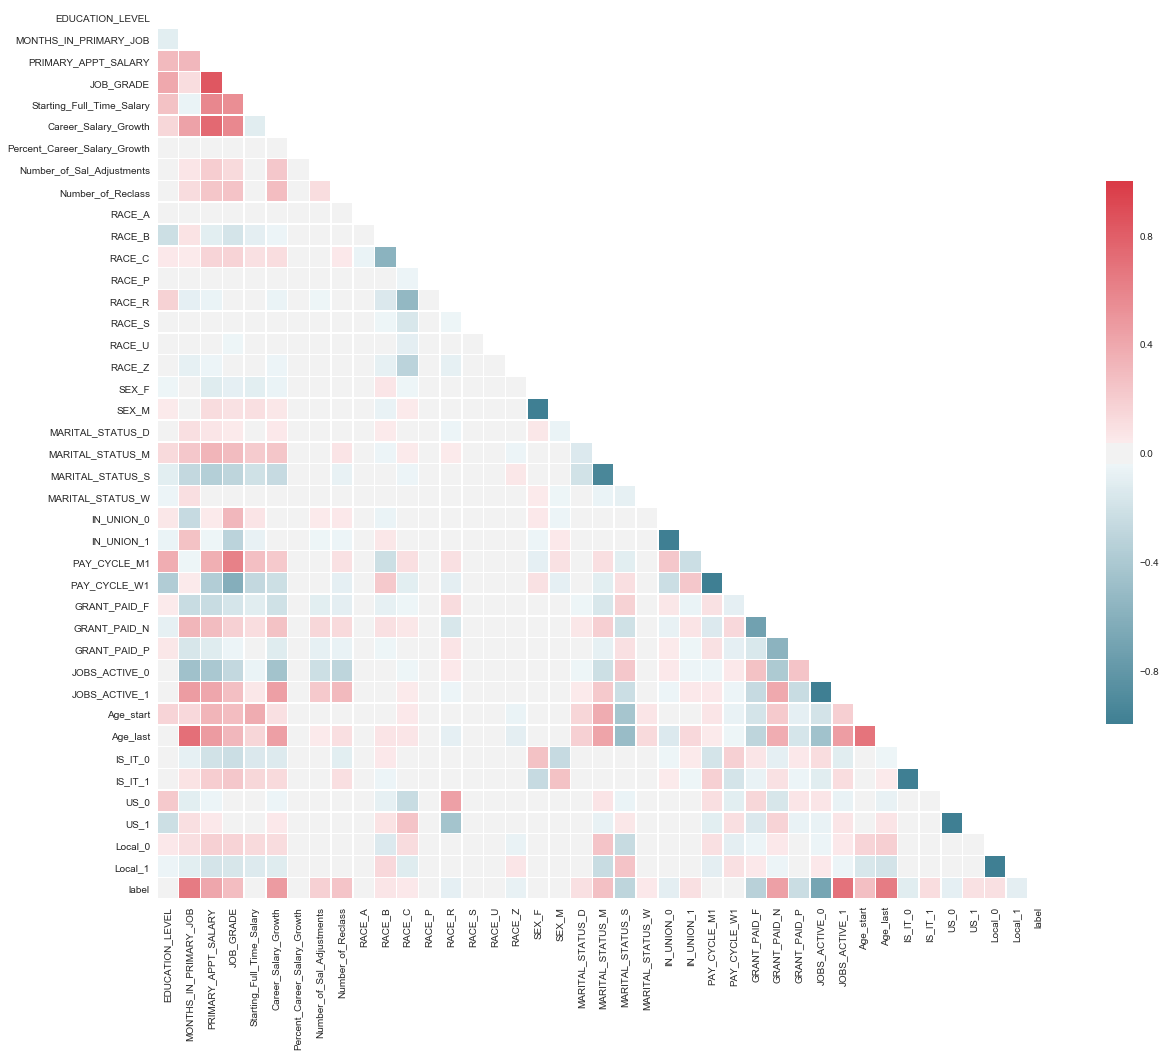

In [26]:
sns.set(style="white")

corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='label'), data[['label']], test_size=0.3)
lr = LogisticRegression().fit(x_train, y_train)
score = lr.score(x_test, y_test)
print(score)

0.9644414625964441


/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
